In [31]:
import os
from pathlib import Path
home = os.getcwd()
current = home
while 'data' not in os.listdir(current):
    current = Path(current).parent
DATA_FOLDER = os.path.join(current, 'data')
PREPARED_DATA_FOLDER = os.path.join(current, 'prepared_data')

In [32]:
# let's try to understand which products bring the most profit
import pandas as pd
item_order_csv = os.path.join(DATA_FOLDER, 'olist_order_items_dataset.csv')
order_items = pd.read_csv(item_order_csv)
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [33]:
import numpy as np
products_count = order_items.groupby('product_id')['price'].agg(['count']).sort_values('count', ascending=False).reset_index().reset_index()
# products_count.head()
orders = pd.merge(left=order_items, right=products_count, on='product_id', how='inner').sort_values('count', ascending=False)

In [34]:
orders.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,index,count
44648,657c1689361cce2eeaabea76ced5e30f,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2017-12-21 02:12:21,75.0,13.08,0,527
78215,b20541ce2d6f4c7d3b204035f09ea681,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-05-09 04:30:36,69.9,12.43,0,527
72419,a52c52c656d3b3ef3ec72fcdc13c714f,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-04-26 12:31:56,69.9,0.00,0,527
75915,acdb814f2758bfa4cf10c3ce5cb09c81,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-03-12 22:48:55,69.9,21.57,0,527
68781,9d241238f3827aced623154ace551dd9,1,aca2eb7d00ea1a7b8ebd4e68314663af,955fee9216a65b617aa5c0531780ce60,2018-03-16 03:48:52,69.9,12.43,0,527


In [35]:
top_products = orders[orders['index'] < 50]
top_products[top_products['index'] == 49]['count'].min(), top_products[top_products['index'] == 48]['count'].min(), 

(111, 113)

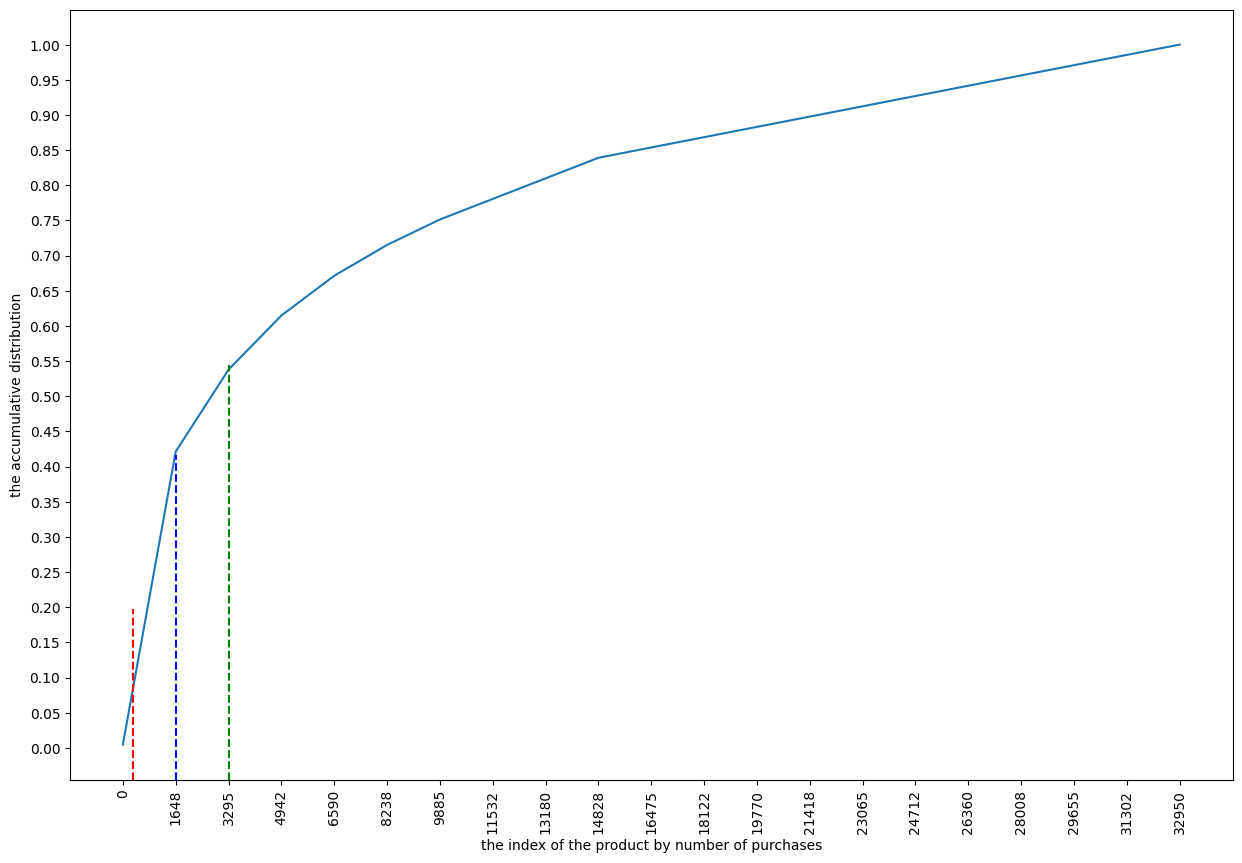

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
# let's build a smart cdf
from statsmodels.distributions.empirical_distribution import ECDF as smart_cdf
x = orders['index']
emperical_cdf = smart_cdf(x)

# let's take a look at this 
sample = np.linspace(0, x.max(), 21)
plt.plot(sample, emperical_cdf(sample))

# let's consider the top 1% , 5% and 10% of the products respectively
qx = np.quantile(np.unique(x), [0.01, 0.05, 0.1]) 
qy = emperical_cdf([int(x) for x in qx])

# let's plot them
for x, y, q, color in zip(qx, qy, [0.01, 0.05, 0.1], ['r', 'b', 'g']):
    plt.axvline(x, ymax=y, color='c', label=f'{100 * q}-th quantile', c=color, linestyle='--')

plt.xticks(sample, rotation=90)
plt.yticks(np.linspace(0, 1, 21))
plt.ylabel('the accumulative distribution')
plt.xlabel('the index of the product by number of purchases')
plt.show()


As we can see the 1% most popular products occupy around 20% of the market share and the top $5\%$ occupy around 40%

In [37]:
top_products = orders[orders['index'] <= qx[0]]
len(top_products)

24916

# Number of pictures and product popularity ?
Can we find enough statistical evidence to determine the significance of image quality and the length of the description on the popularity of the product ?

In [41]:
# let's see how things go !!
products = pd.read_csv(os.path.join(DATA_FOLDER, 'olist_products_dataset.csv'))
df = products.copy()
df.drop(columns=["product_length_cm", "product_height_cm", "product_width_cm"], inplace=True)
ps = top_products.groupby('product_id')['price'].agg(['count']).sort_values(by='count', ascending=False)
pdf = pd.merge(left=df, right=ps, how='inner', on='product_id')
pdf.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,count
0,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,38.0,1176.0,3.0,15350.0,63
1,bbaef2eadf31fe3ea6702077398be06c,perfumaria,45.0,1003.0,2.0,400.0,65
2,c6336fa91fbd87c359e44f5dca5a90ed,esporte_lazer,39.0,772.0,1.0,150.0,94
3,593236d0ff46b4299b4787fb8d43f7f0,industria_comercio_e_negocios,44.0,1396.0,2.0,7225.0,37
4,386486367c1f9d4f587a8864ccb6902b,cama_mesa_banho,54.0,120.0,1.0,835.0,55


In [42]:
# let's try to understand which characteristics affect the product the most: number of photos, description length ? 
pdf['product_photos_qty'].value_counts()
# let's see if the number of photos make a difference 
pdf['multi_photo'] = (pdf['product_photos_qty'] > 2).astype(int)
p0, p1 = pdf[pdf['multi_photo'] == 0], pdf[pdf['multi_photo'] == 1]

In [47]:
pdf.sort_values('count')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,count,multi_photo
63,6bbe55cf8f85c87b6eebb775a53402f4,tablets_impressao_imagem,54.0,512.0,1.0,283.0,33,0
266,7d854ab97c64ef9df2bbfaf332765786,cool_stuff,44.0,598.0,4.0,4100.0,33,1
94,72d3bf1d3a790f8874096fcf860e3eff,brinquedos,57.0,341.0,2.0,583.0,33,0
319,05a9dadb8402b6b7ae3dd28f7da187b5,informatica_acessorios,59.0,3314.0,2.0,2950.0,33,0
144,fe077ec80df6b4ee60bb4498d5ab1962,informatica_acessorios,56.0,195.0,1.0,200.0,33,0
...,...,...,...,...,...,...,...,...
42,368c6c730842d78016ad823897a372db,ferramentas_jardim,57.0,366.0,2.0,1650.0,388,0
299,389d119b48cf3043d311335e499d9c6b,ferramentas_jardim,59.0,341.0,2.0,1750.0,392,0
134,422879e10f46682990de24d770e7f83d,ferramentas_jardim,56.0,348.0,2.0,1550.0,484,0
92,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,54.0,245.0,1.0,1383.0,488,0


In [43]:
len(p0), len(p1)

(237, 93)

(array([74., 10.,  5.,  1.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([ 33. ,  82.4, 131.8, 181.2, 230.6, 280. , 329.4, 378.8, 428.2,
        477.6, 527. ]),
 <BarContainer object of 10 artists>)

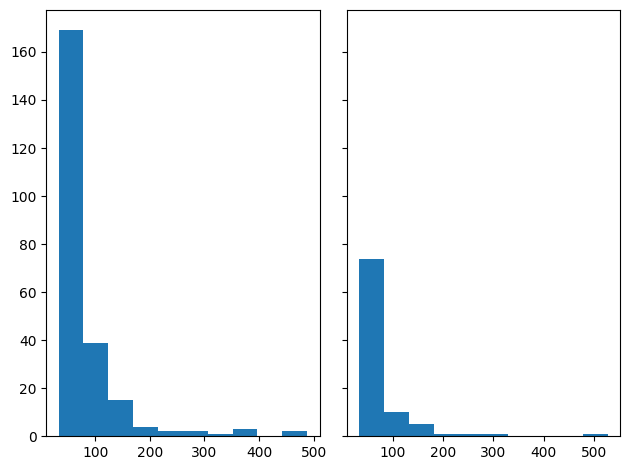

In [44]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(p0['count'], bins=10)
axs[1].hist(p1['count'], bins=10)

In [51]:
# can we see the problem now ?
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(p0['count'].values, p1['count'].values, method='exact')
print(p)

0.07315004603115705


it seems that we do not have enough statistical evident to calims than the number of photos is a determining factor in the popularity of the product

In [ ]:
# let's merge some data
products = pd.read_csv(os.path.join(PREPARED_DATA_FOLDER, 'products_prepared.csv'))
products.head()

In [ ]:
products_eval = pd.merge(left=products, right=products_count, how='inner', on='product_id')
len(products_eval)

In [ ]:
products_eval['product_photos_qty'].value_counts()
products_eval['multiple_phots'] = (products_eval['product_photos_qty'] >= 3).astype(int)

In [ ]:
import matplotlib.pyplot as plt

products_eval.plot.hist(column='count', by='multiple_phots', figsize=(15, 10), bins=100)
# products['product_photos_qty'].hist(bins=range(0, len(categories), 3), figsize=(15, 8))
# plt.xticks(ticks=list(range(0, len(categories), 3)), rotation=90)
# plt.xlabel('categories: mapped to numer1ical values')
# plt.ylabel('frequencies')
# plt.title('frequencies of product categories')
plt.show()

In [ ]:
# let's group the products by their categories and divide them further by their number of photos and decide whether the number of photos is somehow related to 
# populatiry of the product

# let's consider the most popular product categories
# product_categories = products_eval['product_category_name'].unique()
cats = products_eval['product_category_name'].value_counts().index.tolist()

In [ ]:
cat1_prod_eval = products_eval[products_eval['product_category_name'] == cats[4]]
cat1_prod_eval.plot.hist(column='count', by='multiple_phots', figsize=(15, 10), bins=100)
# products['product_photos_qty'].hist(bins=range(0, len(categories), 3), figsize=(15, 8))
# plt.xticks(ticks=list(range(0, len(categories), 3)), rotation=90)
# plt.xlabel('categories: mapped to numer1ical values')
# plt.ylabel('frequencies')
# plt.title('frequencies of product categories')
plt.show()

According to the visualizations, we have little to no evidence to consider a difference in popularity between products with 2 or 1 pictures and those with multiple

# Products and description

In [ ]:
# let's have a simple scatter plot
plt.scatter(x=products_eval['product_description_lenght'], y=products_eval['count'])
plt.show()